<a href="https://colab.research.google.com/github/ffviana/NUTRECON/blob/main/General_FlavorFractal_Analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
!pip install scikit-posthocs
import scikit_posthocs as sp
from matplotlib.patches import Rectangle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
DBfolder_path = '/content/drive/MyDrive/Food Reward and Behaviour/Humans/Projects/2. NUTRECON/FlavorFractal optimization/2. Databases/'

# Flavour Ratings Exploratory analysis

## Data Processing

In [4]:
base_folder = '/content/drive/MyDrive/Food Reward and Behaviour/Humans/Projects/2. NUTRECON/FlavorFractal optimization/'

subjectFigures_folder = base_folder + '3. Analyses/Subject_by_Subject_plots'
registery_fname = base_folder + '2. Databases/subjectFiles_registration.json'
sequenceFolder = base_folder + '1. DataAcquisition/ExperimentsRoom/SitmulusPresentationSequence'
AssTestFolder = base_folder + '1. DataAcquisition/ExperimentsRoom/AssociationTask_ExperimentsRoom'


with open(registery_fname) as json_file:
    registery = json.load(json_file)

subjectFile_Identification = pd.DataFrame.from_records(registery).T
sequenceFiles = subjectFile_Identification['sequence'].tolist()
subjectFile_Identification.tail()

,sequence,association_1,association_2,association_3
ercffa_018,ercffa_018_04-07-2022_08-35.npy,ercffa_018_04-07-2022_09-50.json,ercffa_018_04-07-2022_11-42.json,ercffa_018_05-07-2022_15-29.json
ercffa_019,ercffa_019_05-07-2022_09-47.npy,ercffa_019_05-07-2022_11-47.json,ercffa_019_05-07-2022_12-42.json,ercffa_019_06-07-2022_12-07.json
ercffa_020,ercffa_020_06-07-2022_08-43.npy,ercffa_020_06-07-2022_09-46.json,ercffa_020_06-07-2022_11-15.json,ercffa_020_07-07-2022_10-43.json
ercffa_021,ercffa_021_11-07-2022_08-18.npy,ercffa_021_11-07-2022_09-17.json,ercffa_021_11-07-2022_11-13.json,NaN
ercffa_022,ercffa_022_12-07-2022_09-41.npy,ercffa_022_12-07-2022_11-37.json,ercffa_022_12-07-2022_12-40.json,ercffa_022_13-07-2022_09-46.json


In [5]:
flavorRating_path = DBfolder_path + 'FlavorRatings.xlsx'

flavorRating_df = pd.read_excel(flavorRating_path,header = [0, 1], index_col = 0)
flavorRating_df.dropna(how = 'all', inplace = True)
flavorRating_df.tail()

Apple Cider             Black Currant             Cashew        \
subject_id           N     I     P             N     I     P      N     I   
ercffa_018        31.0  15.0   5.0         100.0  38.0 -38.0   92.0  29.0   
ercffa_019         2.0  19.0  64.0          42.0   5.0   3.0   17.0  29.0   
ercffa_020        36.0  29.0  28.0          66.0  30.0  24.0   62.0  42.0   
ercffa_021        65.0  45.0 -13.0          27.0  22.0 -12.0   96.0  81.0   
ercffa_022        26.0  21.0  35.0           4.0  32.0  -1.0   49.0  32.0   

                 Lychee             Pomegranate             Tamarind        \
subject_id     P      N     I     P           N     I     P        N     I   
ercffa_018  -9.0   13.0  14.0  -4.0        98.0  38.0 -32.0     14.0   8.0   
ercffa_019 -32.0   14.0   5.0   0.0        19.0   5.0   9.0     59.0   5.0   
ercffa_020 -13.0    4.0  40.0  47.0        42.0  38.0  47.0     39.0   8.0   
ercffa_021 -57.0    4.0  13.0  40.0        71.0  59.0 -27.0     79.0  43.0   
ercffa_022  -4.0   27.0  22.0  22.0         7.0  22.0  23.0     60.0  30.0   

                  
subject_id     P  
ercffa_018 -21.0  
ercffa_019  -9.0  
ercffa_020  12.0  
ercffa_021 -25.0  
ercffa_022   3.0

In [6]:
flavorRating_dfLong = pd.melt(flavorRating_df.reset_index(), id_vars='index' )
flavorRating_dfLong.columns = ['subject_id', 'flavor', 'scale', 'score']

flavorRating_dfLong['scale'] = flavorRating_dfLong['scale'].replace({'N':'Novelty', 'P':'Pleasantness', 'I':'Intensity'})
flavorRating_dfLong.head()

,subject_id,flavor,scale,score
0,ercffa_001,Apple Cider,Novelty,19.0
1,ercffa_002,Apple Cider,Novelty,2.0
2,ercffa_003,Apple Cider,Novelty,0.0
3,ercffa_004,Apple Cider,Novelty,11.0
4,ercffa_005,Apple Cider,Novelty,81.0


In [7]:
for fname in sequenceFiles:
  subject_id = fname[:10]
  ffpairs_df_ = np.load('{}/{}'.format(sequenceFolder, fname), 
                        allow_pickle=True).item()['Flavor-Fractal pairs']
  ffpairs_df_ = ffpairs_df_[ffpairs_df_['Flavor']!= 'Plain' ].drop(columns=['Flavor_code'])
  ffpairs_df_['subject_id'] = subject_id
  
  if fname == sequenceFiles[0]:
    ffpairs_df = ffpairs_df_
  else:
    ffpairs_df = pd.concat([ffpairs_df,ffpairs_df_], axis = 0)

ffpairs_df.reset_index(inplace = True)
ffpairs_df

,Fractal,Flavor,subject_id
0,II,Tamarind,ercffa_001
1,IV,Cashew,ercffa_001
2,I,Pomegranate,ercffa_002
3,IV,Black Currant,ercffa_002
4,II,Cashew,ercffa_004
...,...,...,...
85,II,Apple Cider,ercffa_022
86,III,Lychee,ercffa_022
87,IV,Black Currant,ercffa_022
88,V,Tamarind,ercffa_022


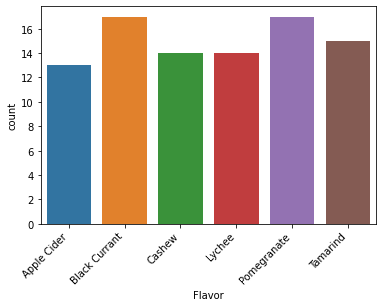

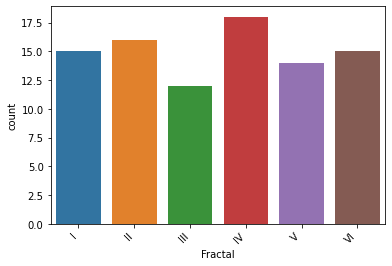

In [8]:
flavorRating_df2 = flavorRating_dfLong.pivot(index=['subject_id', 'flavor'], columns = ['scale'], values = ['score'])
flavorRating_df2 = flavorRating_df2.droplevel(0, axis = 1)
flavorRating_df2.reset_index(inplace=True)

selected_FlavorRatings_df = flavorRating_df2.merge(ffpairs_df, left_on=['subject_id', 'flavor'], right_on = ['subject_id', 'Flavor']).drop(columns=['flavor'])
selected_FlavorRatings_df = selected_FlavorRatings_df[['subject_id', 'Fractal', 'Flavor','Intensity', 'Novelty', 'Pleasantness']]
selected_FlavorRatings_df.to_excel('{}/selected_FlavorRatings.xlsx'.format(DBfolder_path), index = False)

# print(selected_FlavorRatings_df.head(5))

g = sns.countplot(x="Flavor", data=selected_FlavorRatings_df,
          order = sorted(selected_FlavorRatings_df['Flavor'].unique().tolist()))
g.set_xticklabels(g.get_xticklabels() ,rotation=45, ha= 'right');

plt.figure()

g = sns.countplot(x="Fractal", data=selected_FlavorRatings_df,
                  order = ['I', 'II', 'III', 'IV', 'V', 'VI'])
g.set_xticklabels(g.get_xticklabels() ,rotation=45, ha= 'right');

In [9]:
for fname in sequenceFiles:
  subject_id = fname[:10]
  sequence_dic = np.load('{}/{}'.format(sequenceFolder, fname), 
                        allow_pickle=True).item()
  assoc1_correct_ = sequence_dic['Association Test 1']
  assoc1_correct_['subject_id'] = subject_id
  assoc2_correct_ = sequence_dic['Association Test 2']
  assoc2_correct_['subject_id'] = subject_id
  assoc3_correct_ = sequence_dic['Association Test 3']
  assoc3_correct_['subject_id'] = subject_id
  cols = ['subject_id', 'fractal']

  if fname == sequenceFiles[0]:
    assoc1_correct = assoc1_correct_[cols]
    assoc2_correct = assoc2_correct_[cols]
    assoc3_correct = assoc3_correct_[cols]
  else:
    assoc1_correct = pd.concat([assoc1_correct,assoc1_correct_[cols]], axis = 0)
    assoc2_correct = pd.concat([assoc2_correct,assoc2_correct_[cols]], axis = 0)
    assoc3_correct = pd.concat([assoc3_correct,assoc3_correct_[cols]], axis = 0)

sequence_dic.keys()


dict_keys(['Subject ID', 'Timestamp', 'Presentation Order', 'Flavor-Fractal pairs', 'Learning Order', 'Association Test 1', 'Association Test 2', 'Association Test 3'])

In [10]:
assoc1_correct['Association test'] = 'Test 1'
assoc2_correct['Association test'] = 'Test 2'
assoc3_correct['Association test'] = 'Test 3'

assoc_correct = pd.concat([assoc1_correct, assoc2_correct, assoc3_correct], 
                          axis = 0)
assoc_correct.reset_index(inplace = True)

assoc1Files = subjectFile_Identification['association_1'].dropna().tolist()
assoc2Files = subjectFile_Identification['association_2'].dropna().tolist()
assoc3Files = subjectFile_Identification['association_3'].dropna().tolist()

for fname in assoc1Files:
  subject_id = fname[:10]

  AssTest_df = pd.read_json('{}/{}'.format(AssTestFolder, fname))
  AssTest_df['subject_id'] = subject_id
  cols = ['Trial','subject_id', 'Fractal ID']
  assoc1_ans_ = AssTest_df[cols]

  if fname == assoc1Files[0]:
    assoc1_ans = assoc1_ans_
  else:
    assoc1_ans = pd.concat([assoc1_ans, assoc1_ans_], axis = 0)

for fname in assoc2Files:
  subject_id = fname[:10]

  AssTest_df = pd.read_json('{}/{}'.format(AssTestFolder, fname))
  AssTest_df['subject_id'] = subject_id
  cols = ['Trial','subject_id', 'Fractal ID']
  assoc2_ans_ = AssTest_df[cols]

  if fname == assoc2Files[0]:
    assoc2_ans = assoc2_ans_
  else:
    assoc2_ans = pd.concat([assoc2_ans, assoc2_ans_], axis = 0)


for fname in assoc3Files:
  subject_id = fname[:10]

  AssTest_df = pd.read_json('{}/{}'.format(AssTestFolder, fname))
  AssTest_df['subject_id'] = subject_id
  cols = ['Trial','subject_id', 'Fractal ID']
  assoc3_ans_ = AssTest_df[cols]

  if fname == assoc3Files[0]:
    assoc3_ans = assoc3_ans_
  else:
    assoc3_ans = pd.concat([assoc3_ans, assoc3_ans_], axis = 0)

assoc1_ans['Association test'] = 'Test 1'
assoc2_ans['Association test'] = 'Test 2'
assoc3_ans['Association test'] = 'Test 3'

assoc_ans = pd.concat([assoc1_ans, assoc2_ans, assoc3_ans], axis = 0)
assoc_ans['Trial'] = assoc_ans['Trial'] + 1

assocTest = assoc_ans.merge(assoc_correct, left_on=['Trial', 'subject_id', 'Association test'], right_on=['Order','subject_id', 'Association test']).drop(columns=['Trial', 'Order'])
assocTest.columns = ['subject_id', 'Response' ,'Association test', 'Answer']

In [11]:
fractalDecoder = {0: 'Fractal I',
                  1: 'Fractal II',
                  2: 'Fractal III',
                  3: 'Fractal IV',
                  4: 'Fractal V',
                  5: 'Fractal VI'
                  }

acc_df = pd.DataFrame(columns = ['Fractal', 'Nº of correct responses', 'subject_id', 'Association test'])
for subject_id in assocTest['subject_id'].unique():
  df_ = assocTest[assocTest['subject_id'] == subject_id]
  for assTest in df_['Association test'].unique():
    df = df_[df_['Association test'] == assTest]
    response = df['Response'].tolist()
    answers = df['Answer'].tolist()
    matrix = confusion_matrix(answers, response, labels = np.arange(6))
    accuracyPerLabel = matrix.diagonal()
    accuracyPerLabel = accuracyPerLabel[np.unique(answers)]
    labels = [fractalDecoder[p].split(' ')[-1] for p in np.unique(answers)]
    acc_df_ = pd.DataFrame([labels,accuracyPerLabel]).T
    acc_df_['subject_id'] = subject_id
    acc_df_['Association test'] = assTest
    acc_df_.columns = ['Fractal', 'Nº of correct responses', 'subject_id', 'Association test']
    if subject_id == 'ercffa_004':
      print(acc_df_)
    acc_df = pd.concat([acc_df,acc_df_], axis = 0)

acc_df_

  Fractal Nº of correct responses  subject_id Association test
0      II                       6  ercffa_004           Test 1
1      IV                       6  ercffa_004           Test 1
2       V                       6  ercffa_004           Test 1
  Fractal Nº of correct responses  subject_id Association test
0      II                       5  ercffa_004           Test 2
1      IV                       6  ercffa_004           Test 2
2       V                       6  ercffa_004           Test 2
  Fractal Nº of correct responses  subject_id Association test
0      II                       5  ercffa_004           Test 3
1      IV                       6  ercffa_004           Test 3
2       V                       6  ercffa_004           Test 3


,Fractal,Nº of correct responses,subject_id,Association test
0,I,6,ercffa_022,Test 3
1,II,5,ercffa_022,Test 3
2,III,4,ercffa_022,Test 3
3,IV,3,ercffa_022,Test 3
4,V,4,ercffa_022,Test 3
5,VI,2,ercffa_022,Test 3


In [12]:
assocTest

,subject_id,Response,Association test,Answer
0,ercffa_001,0,Test 1,1
1,ercffa_001,3,Test 1,3
2,ercffa_001,3,Test 1,3
3,ercffa_001,1,Test 1,3
4,ercffa_001,2,Test 1,1
...,...,...,...,...
1423,ercffa_022,0,Test 3,0
1424,ercffa_022,1,Test 3,1
1425,ercffa_022,5,Test 3,1
1426,ercffa_022,0,Test 3,0


In [13]:
for fname in sequenceFiles:
  subject_id = fname[:10]
  learning_df_ = np.load('{}/{}'.format(sequenceFolder, fname), 
                        allow_pickle=True).item()['Learning Order']
  learning_df_['subject_id'] = subject_id
  learning_df_.reset_index(inplace = True)
  learning_df_.drop(columns=['Flavor_code'], inplace = True)
  if fname == sequenceFiles[0]:
    learning_df = learning_df_
  else:
    learning_df = pd.concat([learning_df,learning_df_], axis = 0)
learning_df.tail()

,Order,Fractal,Flavor,subject_id
1,2,III,Lychee,ercffa_022
2,3,II,Apple Cider,ercffa_022
3,4,V,Tamarind,ercffa_022
4,5,IV,Black Currant,ercffa_022
5,6,I,Cashew,ercffa_022


In [27]:
fractalDecoder = {0: 'Fractal I',
                  1: 'Fractal II',
                  2: 'Fractal III',
                  3: 'Fractal IV',
                  4: 'Fractal V',
                  5: 'Fractal VI'
                  }

confusion_matrix_df = pd.DataFrame(columns = ['i_fractal', 'j_fractal', 'correct responses', 'subject_id', 'Association test', 'Fractal'])
for subject_id in assocTest['subject_id'].unique():
  df_ = assocTest[assocTest['subject_id'] == subject_id]
  for assTest in df_['Association test'].unique():
    df = df_[df_['Association test'] == assTest]
    response = df['Response'].tolist()
    answers = df['Answer'].tolist()
    matrix = confusion_matrix(answers, response, labels = np.arange(6))
    test_list = []
    for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
        test_list.append([i,j,matrix[i,j]])

    confusion_matrix_df_ = pd.DataFrame(test_list, columns = ['i_fractal','j_fractal','correct responses'])

 #   confusion_matrix_Longdf_['flavorFractalOrder'] = 'Fractal'
    confusion_matrix_df_['subject_id'] = subject_id
    confusion_matrix_df_['Association test'] = assTest
    confusion_matrix_df_['Fractal'] = [fractalDecoder[p].split(' ')[-1] for p in confusion_matrix_df_['i_fractal'].tolist()]

    confusion_matrix_df = pd.concat([confusion_matrix_df,confusion_matrix_df_], axis = 0)

confusion_matrix_df = confusion_matrix_df.merge(learning_df, left_on = ['subject_id', 'Fractal'], right_on = ['subject_id', 'Fractal'])
confusion_matrix_df.sample(6)

,i_fractal,j_fractal,correct responses,subject_id,Association test,Fractal,Order,Flavor
942,4,0,3,ercffa_014,Test 2,V,2,Pomegranate
434,4,2,0,ercffa_007,Test 1,V,1,Plain
681,5,3,0,ercffa_010,Test 2,VI,6,Plain
1294,1,4,0,ercffa_018,Test 3,II,3,Tamarind
739,4,1,0,ercffa_012,Test 2,V,5,Plain
1669,0,1,0,ercffa_022,Test 3,I,6,Cashew


In [32]:
fractalCoord_Decoder = {'I' : 0,
                  'II' : 1,
                  'III' : 2,
                  'IV' : 3,
                  'V' : 4,
                  'VI' : 5
                  }
flavorDecoder = {'Apple Cider' : 0,
                  'Black Currant' : 1,
                  'Cashew' : 2,
                  'Lychee' : 3,
                  'Pomegranate' : 4,
                  'Tamarind' : 5,
                  'Plain' : np.nan}

orderDecoder = {1 : 0,
                2 : 1,
                3 : 2,
                4 : 3,
                5 : 4,
                6 : 5}

# function to return key for any value
def get_key(my_dict, val):
  for key, value in my_dict.items():
    if val == value:
        return key
  return "key doesn't exist"

def get_confMats(sub_id,test):
  subject_df = confusion_matrix_df[confusion_matrix_df['subject_id'] == sub_id]
  test_df = subject_df[subject_df['Association test'] == test]

  fractalFlavor_code = {}
  for i, row in test_df[['Flavor', 'Fractal']].drop_duplicates().iterrows():
    fractalFlavor_code[row[1]] = row[0]

  fractalOrder_code = {}
  for i, row in test_df[['Order', 'Fractal']].drop_duplicates().iterrows():
    fractalOrder_code[row[1]] = row[0]

  test_df['i_flavor'] = [flavorDecoder[fractalFlavor_code[get_key(fractalCoord_Decoder,p)]] for p in test_df['i_fractal'].tolist()]
  test_df['j_flavor'] = [flavorDecoder[fractalFlavor_code[get_key(fractalCoord_Decoder,p)]] for p in test_df['j_fractal'].tolist()]

  test_df['i_order'] = [orderDecoder[fractalOrder_code[get_key(fractalCoord_Decoder,p)]] for p in test_df['i_fractal'].tolist()]
  test_df['j_order'] = [orderDecoder[fractalOrder_code[get_key(fractalCoord_Decoder,p)]] for p in test_df['j_fractal'].tolist()]

  fractal_confMatrix = np.full((6,6),np.nan)
  order_confMatrix = np.full((6,6),np.nan)
  flavor_confMatrix = np.full((6,6),np.nan)
  for i, row in test_df.iterrows():
    row_ = row.values
    fractal_confMatrix[row_[0], row_[1]] = row_[2]
    order_confMatrix[row_[10], row_[11]] = row_[2]

    try:
      flavor_confMatrix[row_[8], row_[9]] = row_[2]
    except:
      continue
      

  return np.expand_dims(fractal_confMatrix, 2), np.expand_dims(order_confMatrix, 2), np.expand_dims(flavor_confMatrix, 2)


In [33]:
c = 0
for sub_id in confusion_matrix_df['subject_id'].unique()[9:]:
  if c == 0:
    fractal_confMatrix_1, order_confMatrix_1, flavor_confMatrix_1 = get_confMats(sub_id,'Test 1')
    fractal_confMatrix_2, order_confMatrix_2, flavor_confMatrix_2 = get_confMats(sub_id,'Test 2')
    fractal_confMatrix_3, order_confMatrix_3, flavor_confMatrix_3 = get_confMats(sub_id,'Test 3')
    c = 1
  else:
    fractal_confMatrix_1_, order_confMatrix_1_, flavor_confMatrix_1_ = get_confMats(sub_id,'Test 1')
    fractal_confMatrix_2_, order_confMatrix_2_, flavor_confMatrix_2_ = get_confMats(sub_id,'Test 2')
    fractal_confMatrix_3_, order_confMatrix_3_, flavor_confMatrix_3_ = get_confMats(sub_id,'Test 3')

    fractal_confMatrix_1 = np.dstack((fractal_confMatrix_1, fractal_confMatrix_1_))
    fractal_confMatrix_2 = np.dstack((fractal_confMatrix_2, fractal_confMatrix_2_))
    fractal_confMatrix_3 = np.dstack((fractal_confMatrix_3, fractal_confMatrix_3_))

    order_confMatrix_1 = np.dstack((order_confMatrix_1, order_confMatrix_1_))
    order_confMatrix_2 = np.dstack((order_confMatrix_2, order_confMatrix_2_))
    order_confMatrix_3 = np.dstack((order_confMatrix_2_, order_confMatrix_3_))

    flavor_confMatrix_1 = np.dstack((flavor_confMatrix_1, flavor_confMatrix_1_))
    flavor_confMatrix_2 = np.dstack((flavor_confMatrix_2, flavor_confMatrix_2_))
    flavor_confMatrix_3 = np.dstack((flavor_confMatrix_3, flavor_confMatrix_3_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

## Are gLMS and gLHS different between Flavors?

### Novelty, Intensity and Pleasanteness Histograms


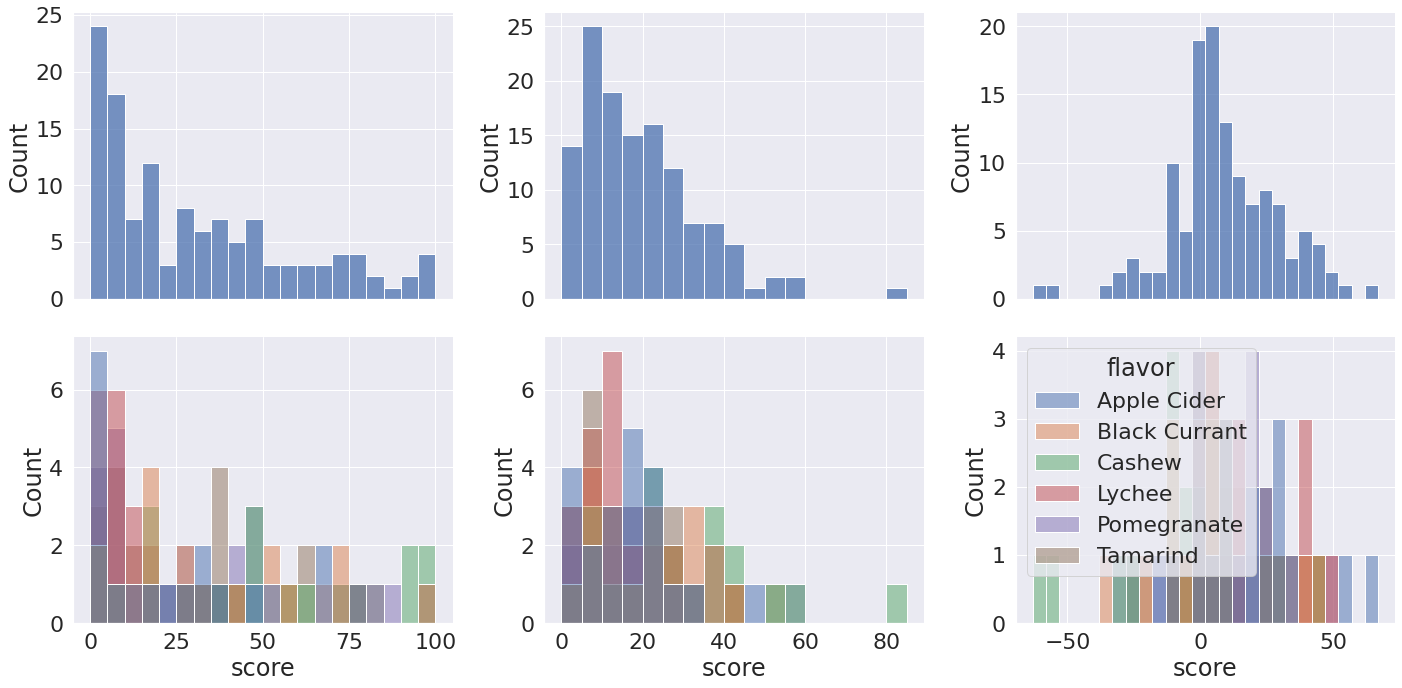

In [38]:
sns.set(font_scale = 2)
#sns.set_style("white")
cols = 3
rows = 2
fig, axes = plt.subplots(figsize = [20,10],nrows=2, ncols=cols, sharex = 'col')
i = 0

for scale in flavorRating_dfLong['scale'].unique():
  sub_df = flavorRating_dfLong[flavorRating_dfLong['scale'] == scale]
  sns.histplot(data=sub_df,x = 'score', binwidth = 5, ax=axes[i//cols,i%cols])
  sns.despine()
  i += 1

for scale in flavorRating_dfLong['scale'].unique():
  sub_df = flavorRating_dfLong[flavorRating_dfLong['scale'] == scale]
  sns.histplot(data=sub_df, x = 'score', hue = 'flavor', binwidth = 5, ax=axes[i//cols,i%cols])
  sns.despine()
  if i < 5:
    axes[i//cols,i%cols].get_legend().remove()
  i += 1
plt.tight_layout()

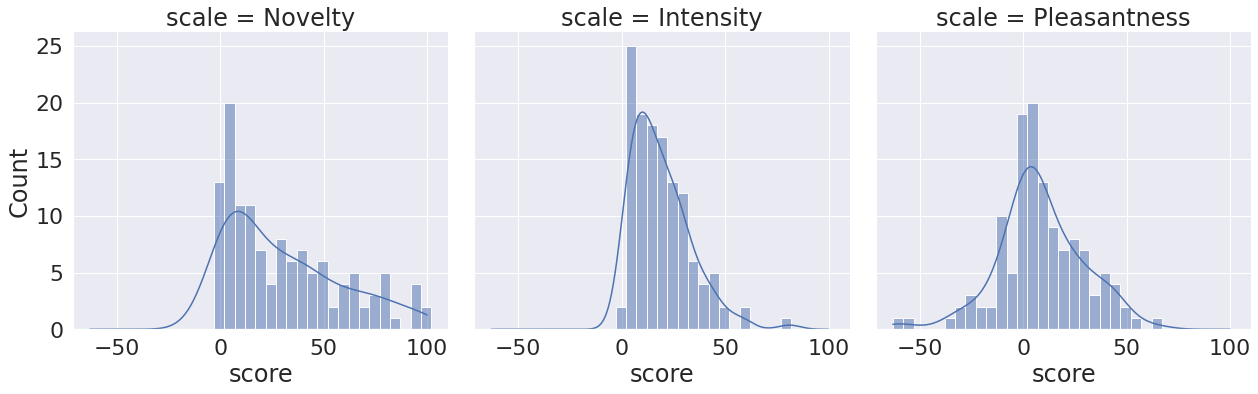

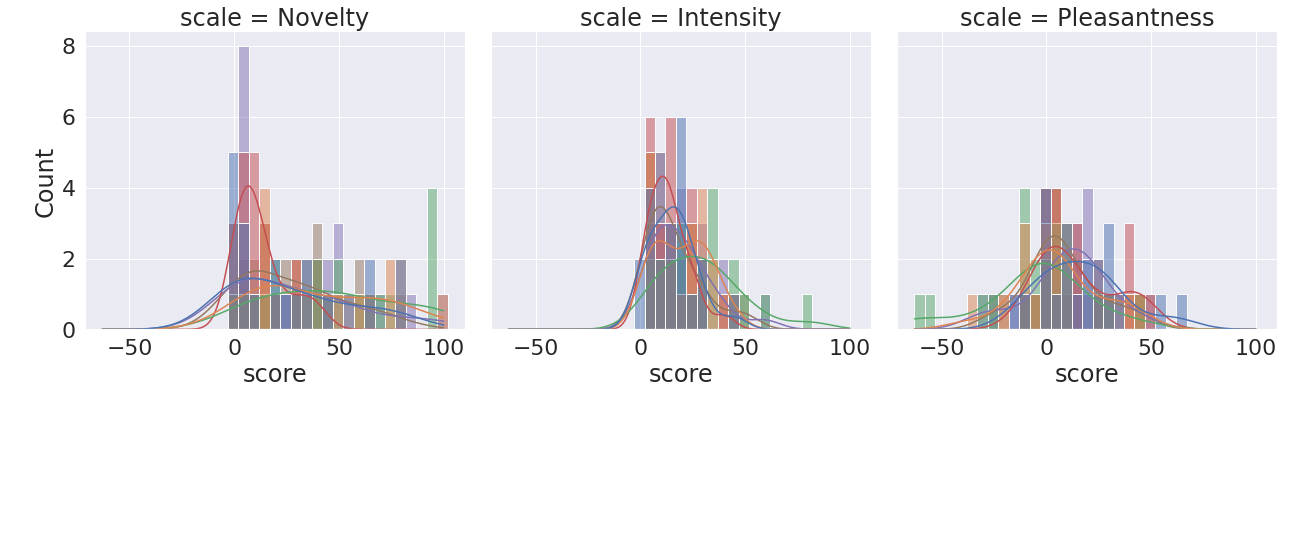

In [39]:
sns.set(font_scale = 2)
#sns.set_style("white")
sns.displot(data=flavorRating_dfLong, x="score", col="scale", kde=True, binwidth = 5,height = 6, aspect = 1)
plt.tight_layout()

g = sns.displot(data=flavorRating_dfLong, x="score", hue="flavor", col="scale", kde=True, binwidth = 5,height = 6, aspect = 1, facet_kws=dict(legend_out=False))
sns.move_legend(g, "upper center",
    bbox_to_anchor=(.5, -.2), ncol=6, title=None, frameon=False)

plt.tight_layout()

### Novelty, Intensity and Pleasanteness Boxplots

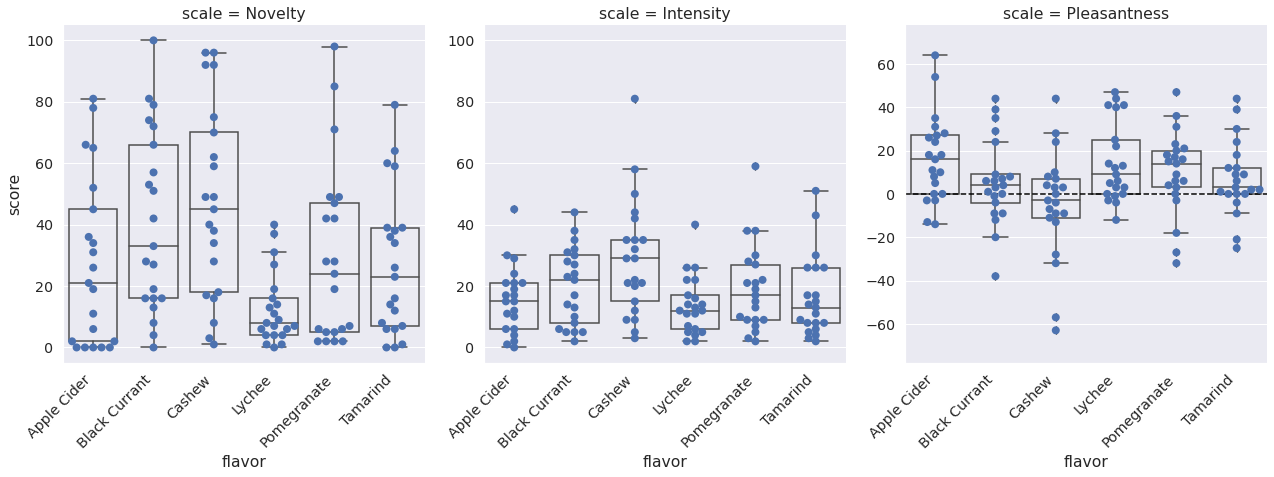

In [40]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False};
sns.set_theme(style="whitegrid", rc=custom_params, palette = 'colorblind');
sns.set(font_scale=1.3);

g = sns.FacetGrid(flavorRating_dfLong, col="scale", col_order = ['Novelty', 'Intensity', 'Pleasantness'], sharey = False, legend_out =True,  height = 6, aspect = 1);
g.map_dataframe(sns.swarmplot, x="flavor", y="score", size=8);
g.map_dataframe(sns.boxplot, x="flavor", y="score", boxprops=dict(facecolor=(0,0,0,0)));
g.set_xticklabels(rotation=45, ha= 'right');
g.axes[0,0].set_ylim([-5,105]);
g.axes[0,1].set_ylim([-5,105]);
g.axes[0,2].set_ylim([-78,78]);
g.axes[0,2].axhline(0, ls = '--', c = 'black');



### Statistics

In [41]:
mc_method = 'fdr_by'
print(33*'=')
print(' '*10, 'parametric')
print(33*'=')

for scale in flavorRating_dfLong['scale'].unique():
  print(10*'-',scale, 10*'-')
  sub_df = flavorRating_dfLong[flavorRating_dfLong['scale'] == scale]
  model_lm = ols('score ~ C(flavor)', data=sub_df).fit()
  anova_table = sm.stats.anova_lm(model_lm, typ=2)
  print(anova_table)
  if anova_table.iloc[0,-1] < 0.05:
    print()
    print(sp.posthoc_ttest(sub_df, val_col='score', group_col='flavor', p_adjust=mc_method))

print()
print(33*'=')
print(' '*8, 'non-parametric')
print(33*'=')

for scale in flavorRating_dfLong['scale'].unique():
  print(10*'-',scale, 10*'-')
  sub_df = flavorRating_dfLong[flavorRating_dfLong['scale'] == scale]
  data = [sub_df.loc[ids, 'score'].values for ids in sub_df.groupby('flavor').groups.values()]
  kruskal_res = stats.kruskal(*data)
  print(kruskal_res)
  if kruskal_res[1] < 0.05:
    print(sp.posthoc_conover(sub_df, val_col='score', group_col='flavor', p_adjust=mc_method))
  print()

           parametric
---------- Novelty ----------
                 sum_sq     df         F    PR(>F)
C(flavor)  15133.753968    5.0  4.384986  0.001059
Residual   82830.380952  120.0       NaN       NaN

               Apple Cider  Black Currant    Cashew    Lychee  Pomegranate  \
Apple Cider       1.000000       0.689328  0.260542  0.247996     1.000000   
Black Currant     0.689328       1.000000  1.000000  0.005659     0.998497   
Cashew            0.260542       1.000000  1.000000  0.001393     0.411497   
Lychee            0.247996       0.005659  0.001393  1.000000     0.224992   
Pomegranate       1.000000       0.998497  0.411497  0.224992     1.000000   
Tamarind          1.000000       0.572011  0.235776  0.224992     1.000000   

               Tamarind  
Apple Cider    1.000000  
Black Currant  0.572011  
Cashew         0.235776  
Lychee         0.224992  
Pomegranate    1.000000  
Tamarind       1.000000  
---------- Intensity ----------
                 sum_sq     df   

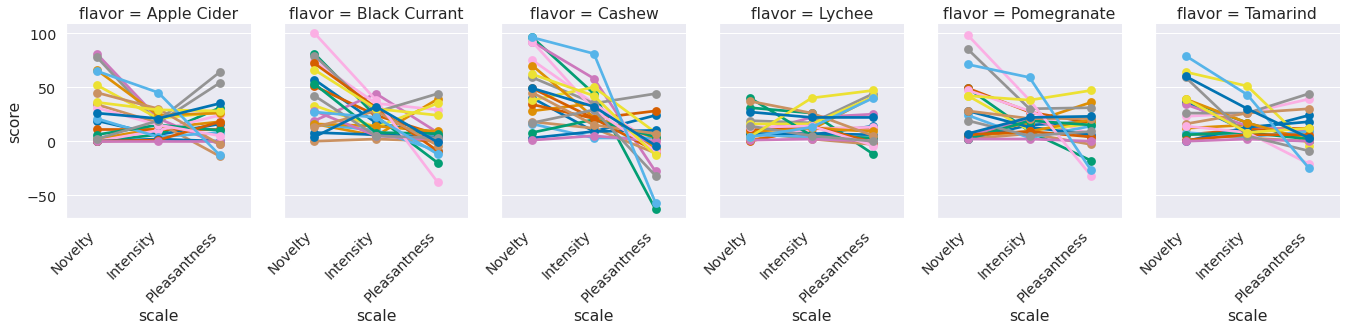

In [42]:
g = sns.FacetGrid(flavorRating_dfLong, col = "flavor", legend_out =True,  height = 4, aspect = .8)
g.map_dataframe(sns.pointplot, x="scale", y="score", hue = 'subject_id', size=10, palette=sns.color_palette('colorblind'))
g.set_xticklabels(rotation=45, ha= 'right')

In [43]:
flavorRating_dfLong_2 = flavorRating_dfLong.pivot(index = ['subject_id', 'flavor'], columns='scale', values = ['score'])
flavorRating_df2 = flavorRating_dfLong_2.reset_index()
flavorRating_df2 = flavorRating_df2.droplevel(0,axis=1)
flavorRating_df2.columns = ['subject_id', 'flavor','Intensity', 'Novelty', 'Pleasantness']
flavorRating_df2.columns.name = ''
flavorRating_df2.tail(6)

,subject_id,flavor,Intensity,Novelty,Pleasantness
120,ercffa_022,Apple Cider,21.0,26.0,35.0
121,ercffa_022,Black Currant,32.0,4.0,-1.0
122,ercffa_022,Cashew,32.0,49.0,-4.0
123,ercffa_022,Lychee,22.0,27.0,22.0
124,ercffa_022,Pomegranate,22.0,7.0,23.0
125,ercffa_022,Tamarind,30.0,60.0,3.0


(0.6465928670630505, 2.887117012226603e-16)


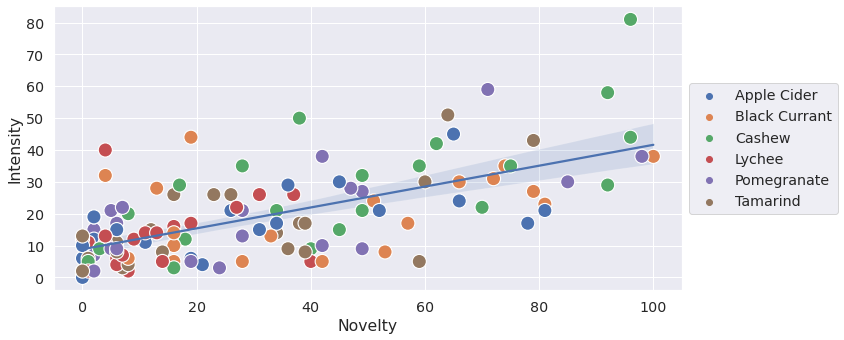

In [44]:
fig, ax = plt.subplots(figsize = [12,5])
sns.regplot(x='Novelty', y='Intensity', data=flavorRating_df2, scatter = False, ax = ax)
sns.scatterplot(data=flavorRating_df2, x='Novelty', y="Intensity", hue="flavor", 
                ax = ax, s=200)#, style='Selected', markers=[ 'X', 'o'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.vlines(6, ymin = 35, ymax = ymax)
#ax.vlines(6, ymin = 6, ymax = ymax, ls = '--')

#ax.hlines(35, xmin = 6, xmax = xmax)
#ax.hlines(6, xmin = 6, xmax = xmax, ls = '--')
#ax.hlines(50, xmin = 6, xmax = xmax, ls = 'dotted')
#ax.set_ylim([-5, ymax])
plt.tight_layout()

from scipy.stats import pearsonr
print(pearsonr(flavorRating_df2["Intensity"], flavorRating_df2["Novelty"]))

## Is The Accuracy diffent between Flavour or Fractals?

In [45]:
FlavorFractalAccuracy_df = acc_df.merge(selected_FlavorRatings_df, left_on = ['subject_id', 'Fractal'],right_on = ['subject_id', 'Fractal'])
FlavorFractalAccuracy_df.head()

,Fractal,Nº of correct responses,subject_id,Association test,Flavor,Intensity,Novelty,Pleasantness
0,II,0,ercffa_001,Test 1,Tamarind,9.0,36.0,24.0
1,II,0,ercffa_001,Test 2,Tamarind,9.0,36.0,24.0
2,IV,3,ercffa_001,Test 1,Cashew,9.0,40.0,24.0
3,IV,1,ercffa_001,Test 2,Cashew,9.0,40.0,24.0
4,I,4,ercffa_002,Test 1,Pomegranate,17.0,6.0,36.0


### Group-Level

#### Flavour

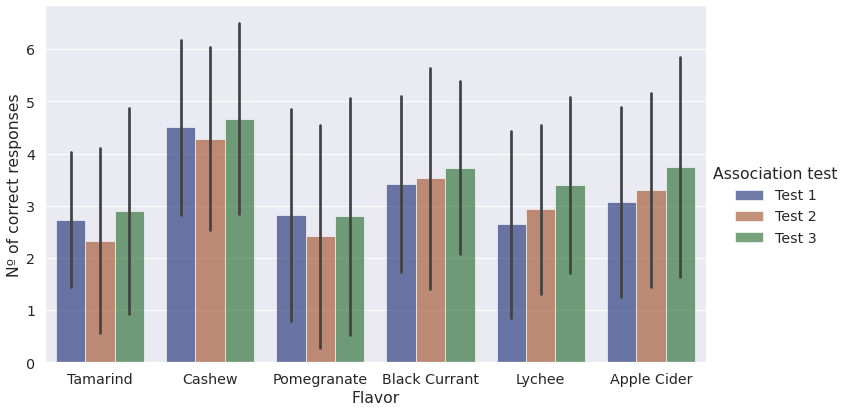

In [46]:

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=FlavorFractalAccuracy_df, kind="bar",
    y="Nº of correct responses", x="Flavor", hue="Association test",
    ci="sd", palette="dark", alpha=.6, height=6, aspect = 1.7
)

#### Fractals

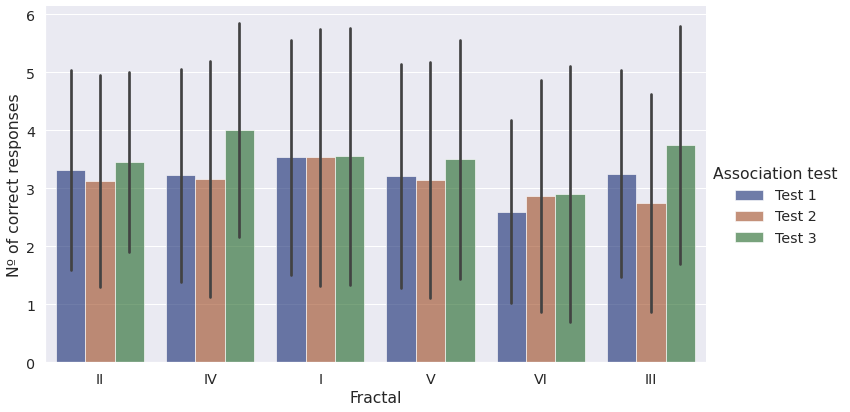

In [47]:
g = sns.catplot(
    data=FlavorFractalAccuracy_df, kind="bar",
    y="Nº of correct responses", x="Fractal", hue="Association test",
    ci="sd", palette="dark", alpha=.6, height=6, aspect = 1.7
)

### Per subject



#### Flavor

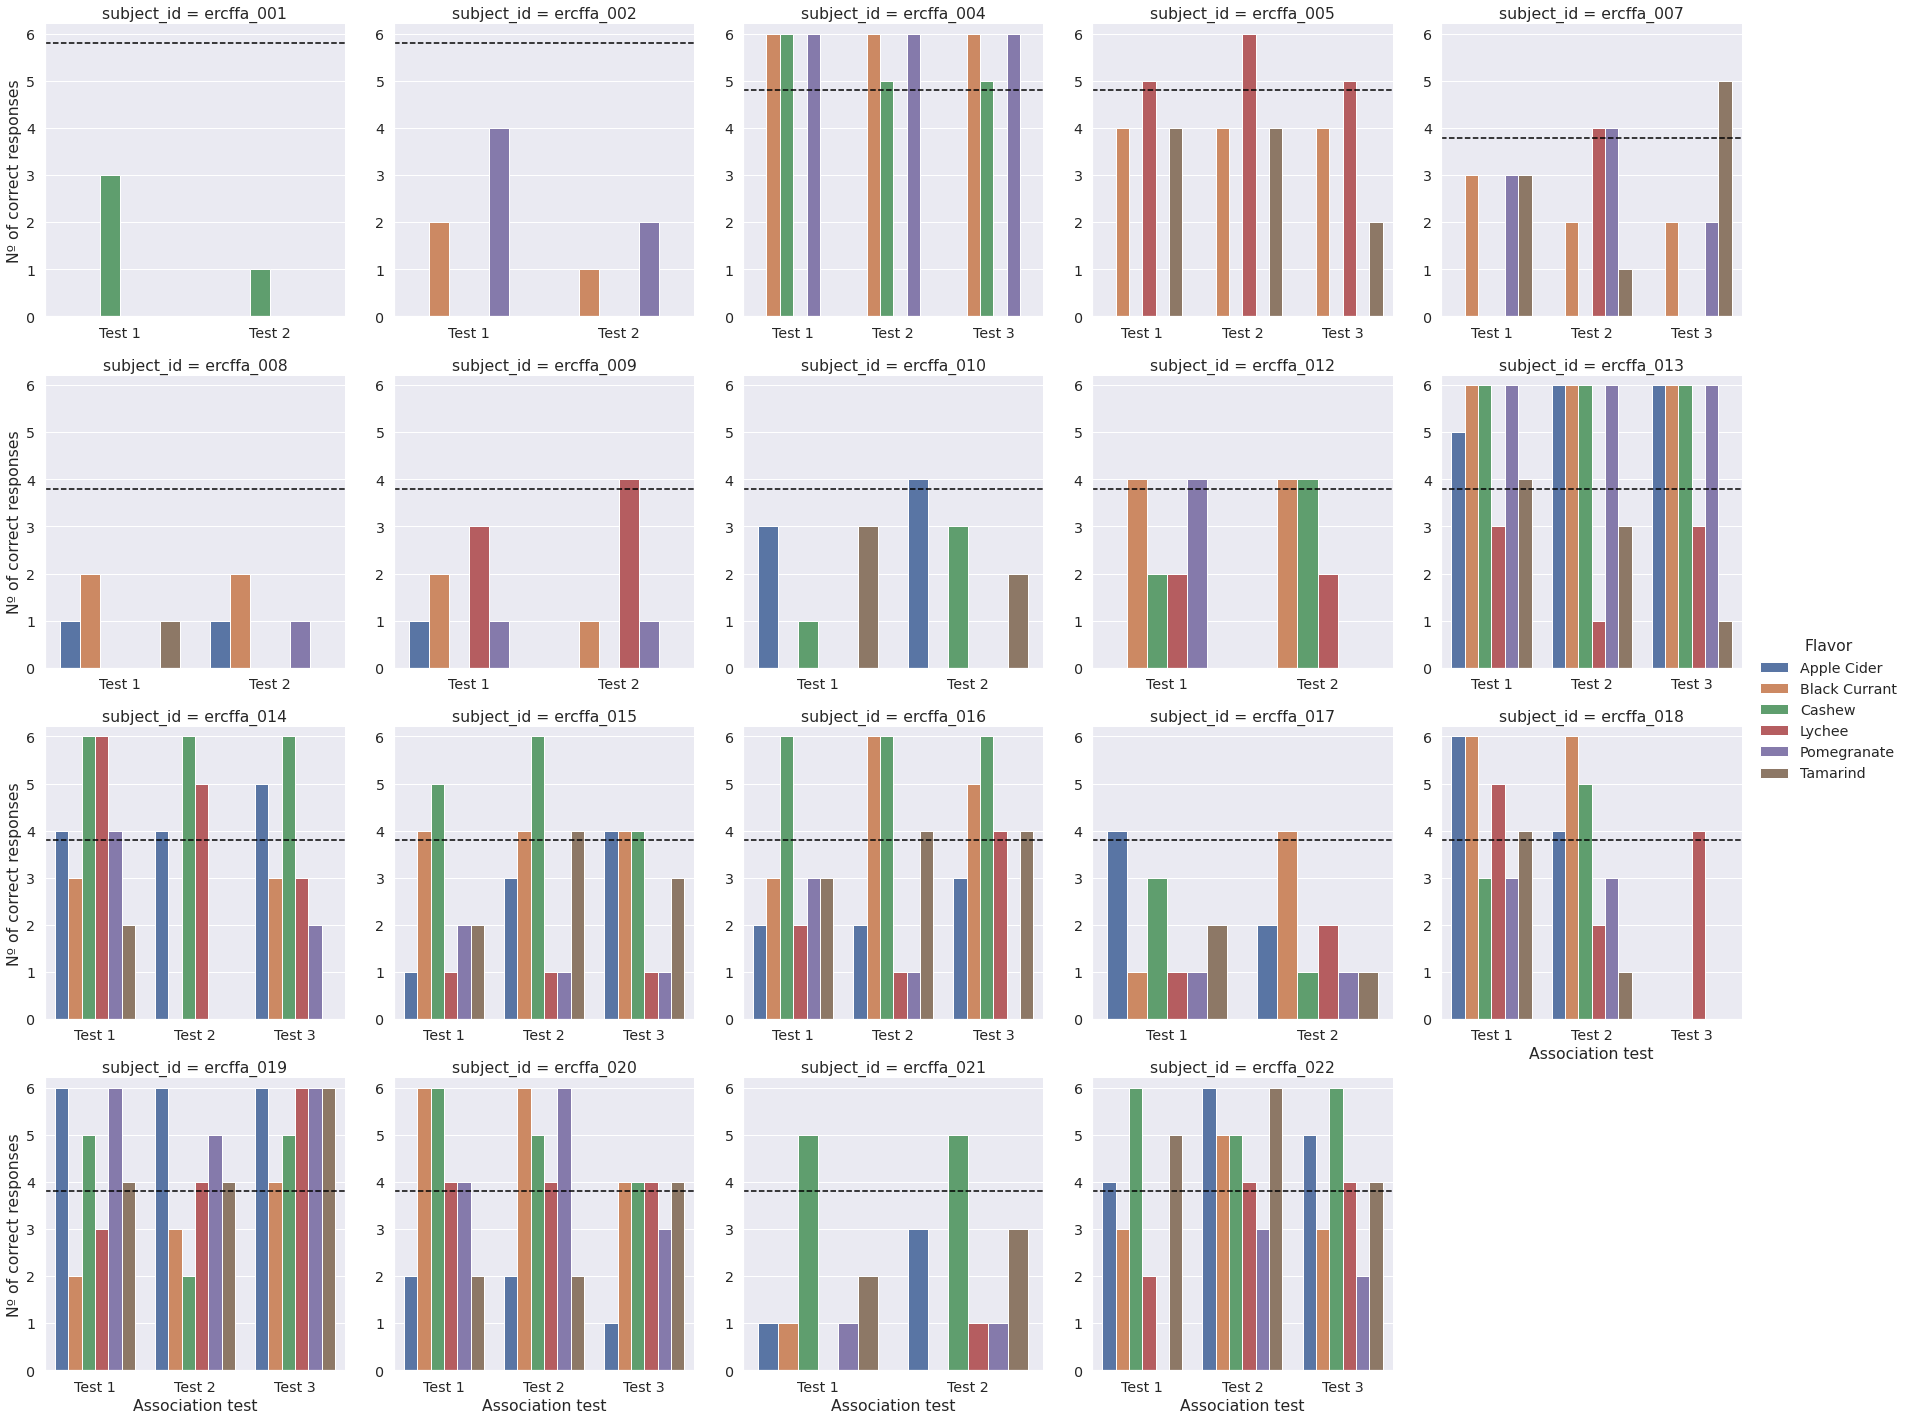

In [48]:
g = sns.catplot(hue="Flavor", y = 'Nº of correct responses', 
                x = 'Association test', col="subject_id", col_wrap=5,
                hue_order = sorted(FlavorFractalAccuracy_df['Flavor'].unique()),
                data=FlavorFractalAccuracy_df, kind="bar", sharex = False, sharey = False,ci = None)#, height=2.5, aspect=.8)

c = 0
for ax in g.axes:
  ax.set_ylim(0, 6.2)
  if c < 2:
    ax.axhline(6-.2,ls='--',c = 'black')
  elif c < 4:
    ax.axhline(5-.2,ls='--',c = 'black')
  else:
    ax.axhline(4-.2,ls='--',c = 'black')
  c += 1

#### Fractal

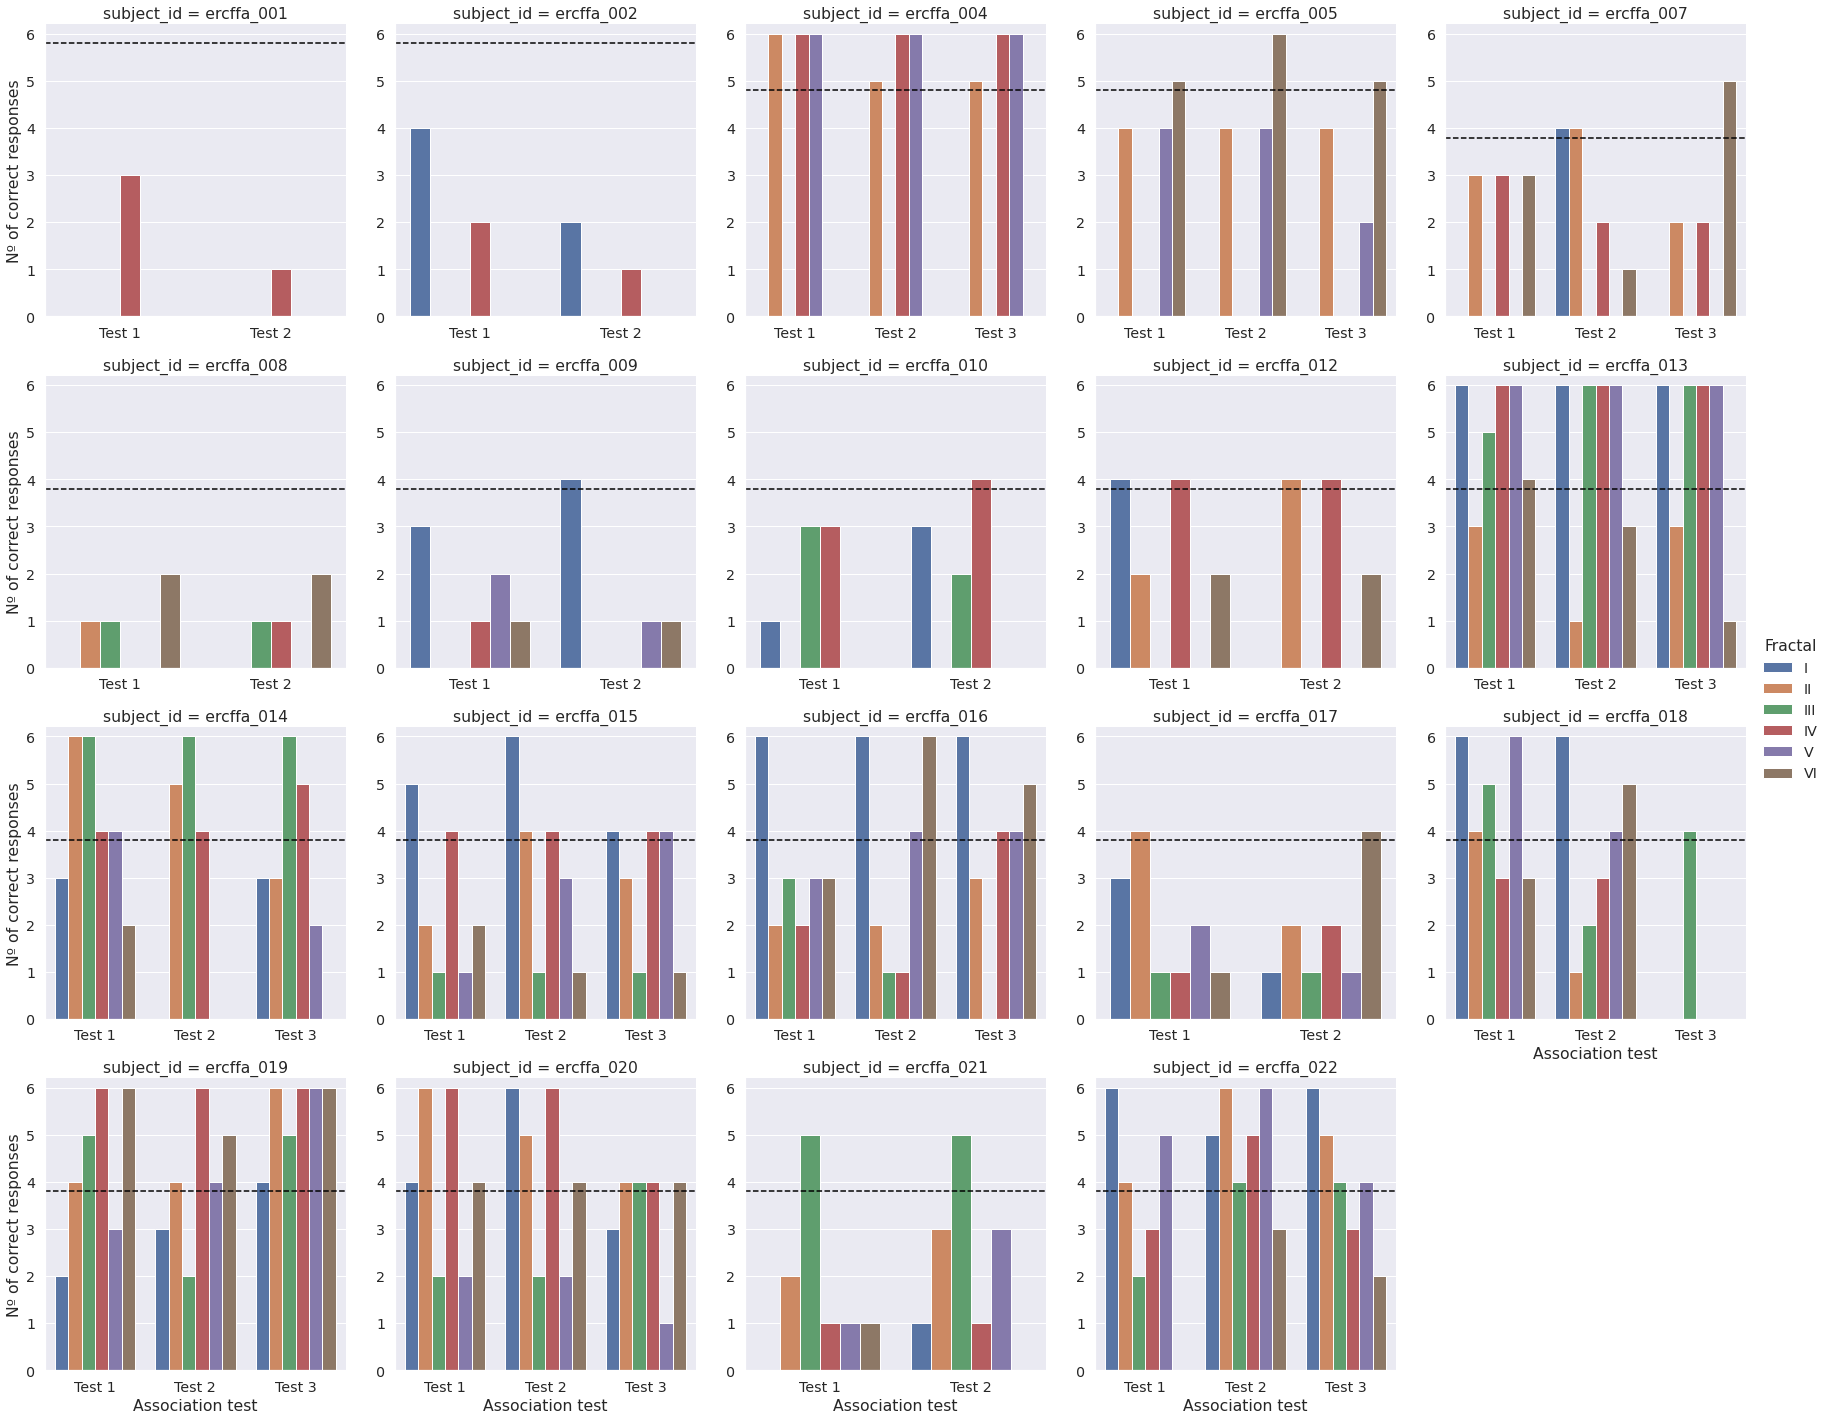

In [49]:
g = sns.catplot(hue="Fractal", y = 'Nº of correct responses', 
                x = 'Association test', col="subject_id", col_wrap=5,
                hue_order = ['I', 'II', 'III', 'IV', 'V', 'VI'],
                data=acc_df, kind="bar", sharex = False, sharey = False,ci = None)#, height=2.5, aspect=.8)

c = 0
for ax in g.axes:
  ax.set_ylim(0, 6.2)
  if c < 2:
    ax.axhline(6-.2,ls='--',c = 'black')
  elif c < 4:
    ax.axhline(5-.2,ls='--',c = 'black')
  else:
    ax.axhline(4-.2,ls='--',c = 'black')
  c += 1


## Is there a association between gLMS and gLHS ratings and Accuracy?

In [50]:
FlavorFractalAccuracy_df.head()

,Fractal,Nº of correct responses,subject_id,Association test,Flavor,Intensity,Novelty,Pleasantness
0,II,0,ercffa_001,Test 1,Tamarind,9.0,36.0,24.0
1,II,0,ercffa_001,Test 2,Tamarind,9.0,36.0,24.0
2,IV,3,ercffa_001,Test 1,Cashew,9.0,40.0,24.0
3,IV,1,ercffa_001,Test 2,Cashew,9.0,40.0,24.0
4,I,4,ercffa_002,Test 1,Pomegranate,17.0,6.0,36.0


### Group-level

#### Scales per Correct Responses

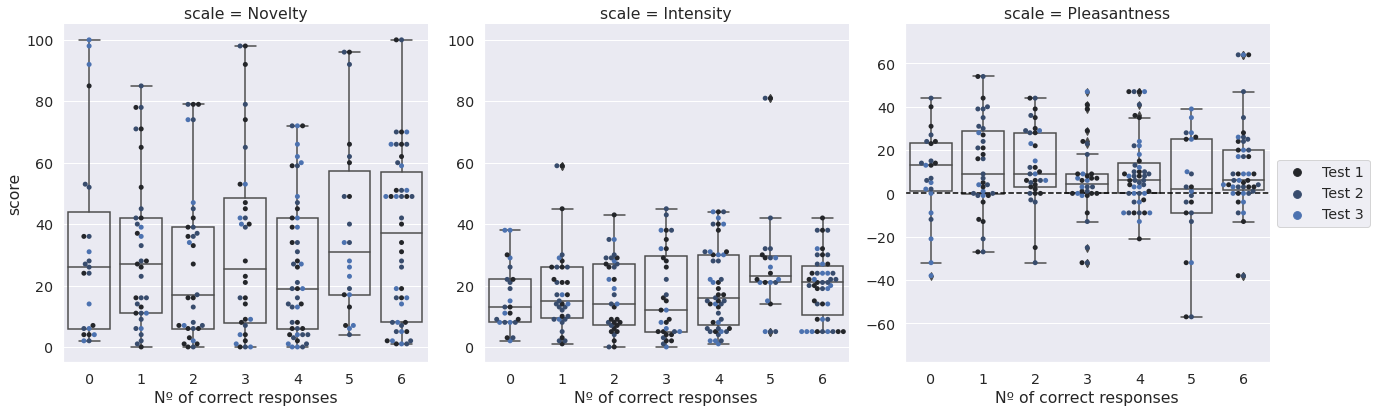

In [51]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False};
sns.set_theme(style="whitegrid", rc=custom_params, palette = 'pastel');
sns.set(font_scale=1.3);
FlavorFractalAccuracy_Longdf = FlavorFractalAccuracy_df.melt(id_vars=['Fractal', 'Nº of correct responses', 'subject_id', 'Association test',
       'Flavor'], var_name='scale', value_name='score')
g = sns.FacetGrid(FlavorFractalAccuracy_Longdf, col="scale", col_order = ['Novelty', 'Intensity', 'Pleasantness'], sharey = False,  height = 6, aspect = 1);
g.map_dataframe(sns.swarmplot, x="Nº of correct responses", y="score", hue = 'Association test');
g.map_dataframe(sns.boxplot,x="Nº of correct responses", y="score", boxprops=dict(facecolor=(0,0,0,0)));
g.axes[0,0].set_ylim([-5,105]);
g.axes[0,1].set_ylim([-5,105]);
g.axes[0,2].set_ylim([-78,78]);
g.axes[0,2].axhline(0, ls = '--', c = 'black');
g.axes[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Scales per Correct Responses for each Flavor

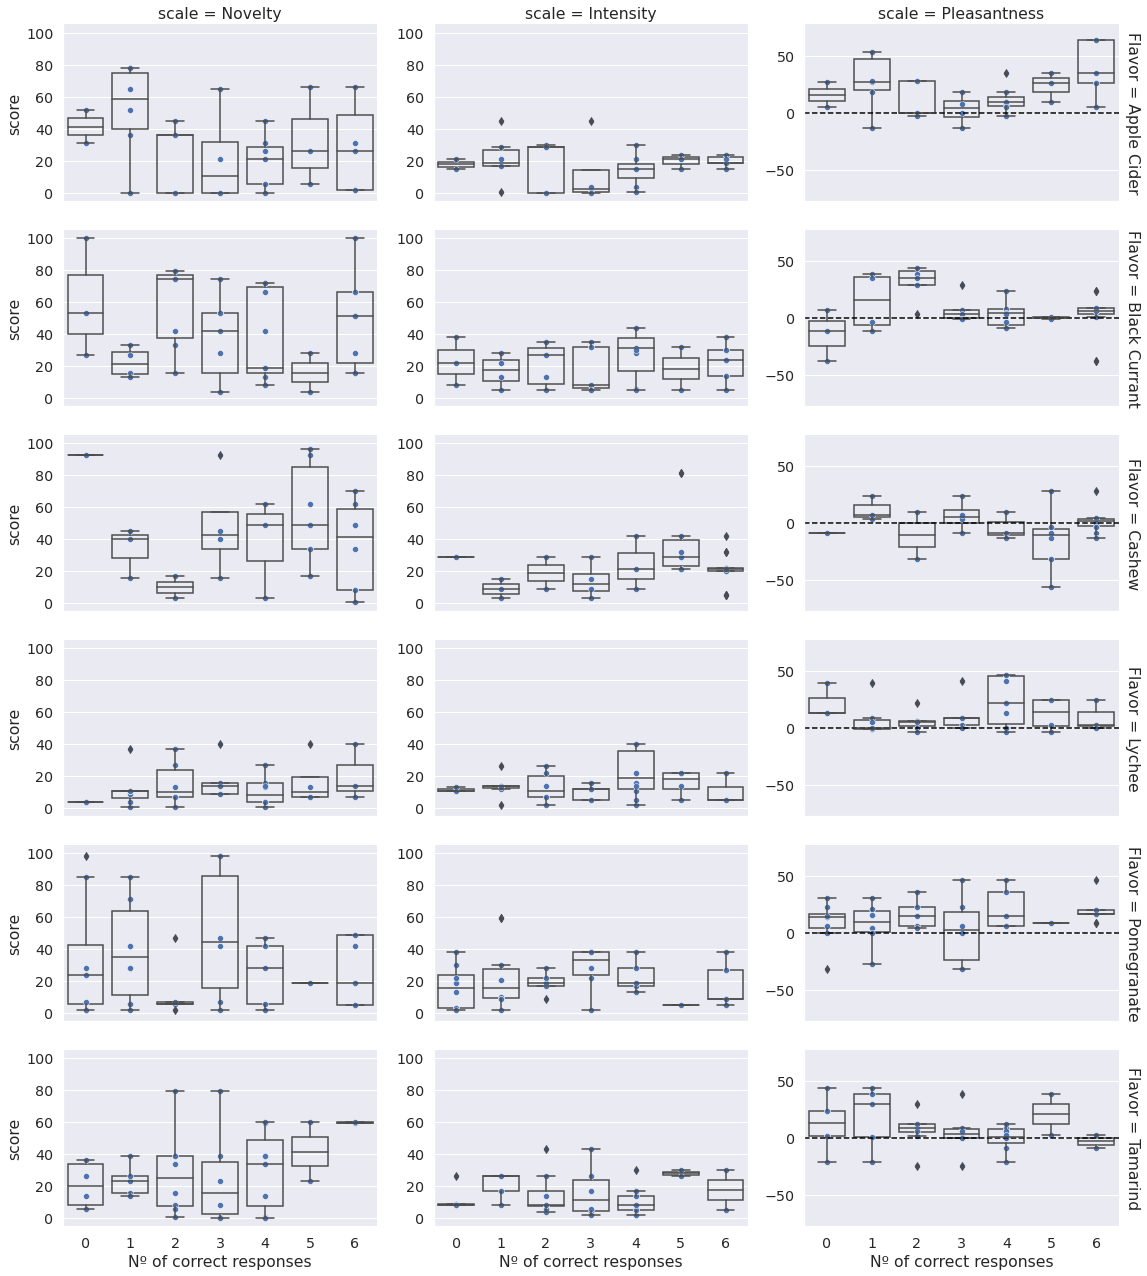

In [52]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False};
sns.set_theme(style="whitegrid", rc=custom_params, palette = 'pastel');
sns.set(font_scale=1.3);

g = sns.FacetGrid(FlavorFractalAccuracy_Longdf, 
                  col="scale", col_order = ['Novelty', 'Intensity', 'Pleasantness'],
                  row = 'Flavor', row_order = sorted(FlavorFractalAccuracy_df['Flavor'].unique()) ,
                  sharey = False,sharex = True,  height = 3, aspect = 1.8, margin_titles=True);
g.map_dataframe(sns.scatterplot, x="Nº of correct responses", y="score");
g.map_dataframe(sns.boxplot, x="Nº of correct responses", y="score",boxprops=dict(facecolor=(0,0,0,0)));

for ax in g.axes[:,0]:
  ax.set_ylim([-5,105]);
for ax in g.axes[:,1]:
  ax.set_ylim([-5,105]);
for ax in g.axes[:,2]:
  ax.set_ylim([-78,78]);
  ax.axhline(0, ls = '--', c = 'black');
  #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Subject-level

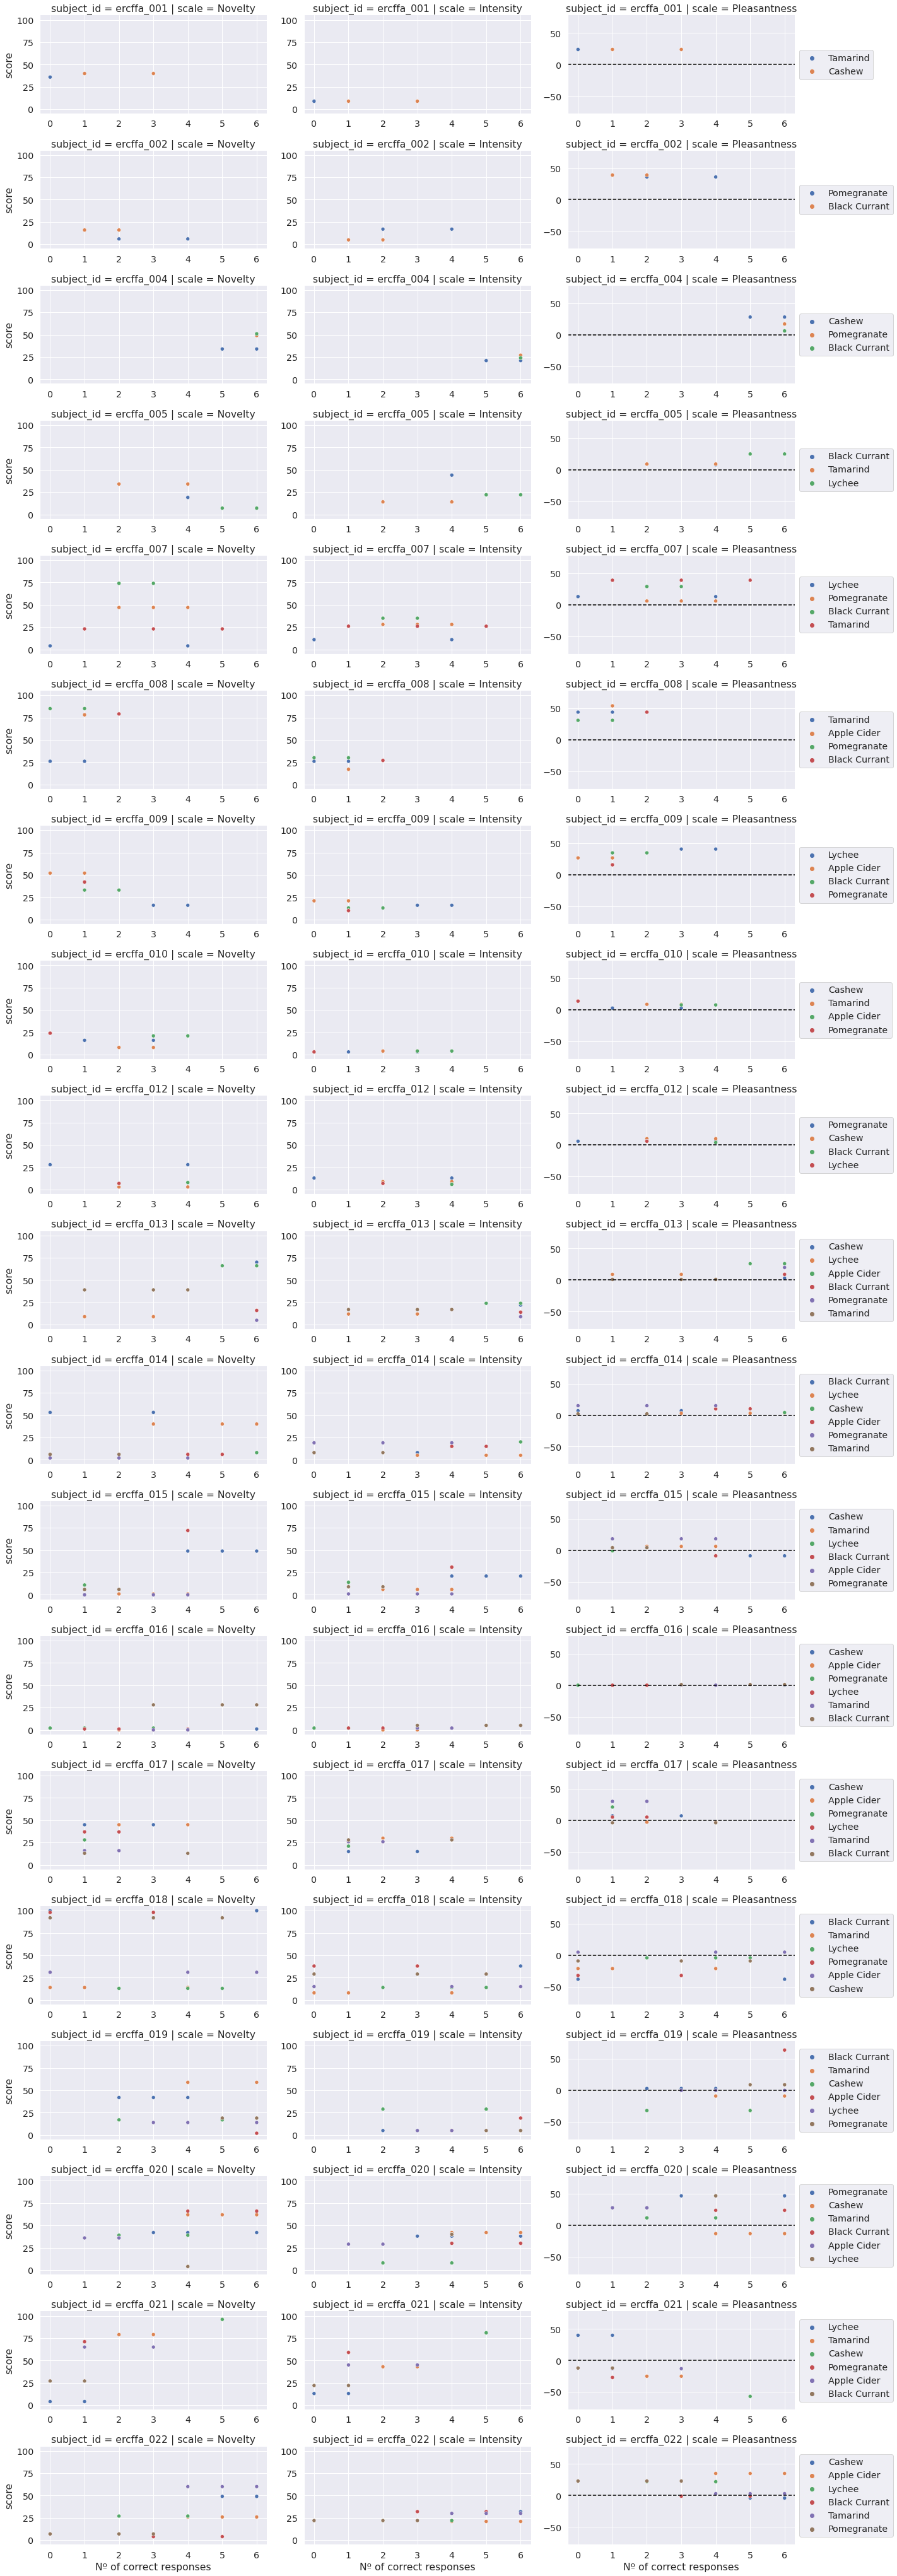

In [53]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False};
sns.set_theme(style="whitegrid", rc=custom_params, palette = 'pastel');
sns.set(font_scale=1.3);

g = sns.FacetGrid(FlavorFractalAccuracy_Longdf, col="scale", col_order = ['Novelty', 'Intensity', 'Pleasantness'],
                  row = 'subject_id', sharey = False,sharex = False,  height = 3, aspect = 2);
g.map_dataframe(sns.scatterplot, x="Nº of correct responses", y="score", hue = 'Flavor');

for ax in g.axes[:,0]:
  ax.set_ylim([-5,105]);
  ax.set_xlim([-0.30000000000000004, 6.3]);
for ax in g.axes[:,1]:
  ax.set_ylim([-5,105]);
  ax.set_xlim([-0.30000000000000004, 6.3]);
for ax in g.axes[:,2]:
  ax.set_ylim([-78,78]);
  ax.set_xlim([-0.30000000000000004, 6.3]);
  ax.axhline(0, ls = '--', c = 'black');
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Confusion Matrix

In [166]:
def plot_heatmap(mat, labels, ax, title_label):

  sns.heatmap(mat.T, square=True, annot=True, cbar=False, ax = ax)
  rect = Rectangle((.5,0),np.sqrt(2*5.5**2),np.sqrt(2)/2, ec='green', lw = 4, fc = 'none', angle = 45)

  ax.tick_params( direction = 'inout' )
  ax.set_title(title_label)
  ax.set_xlabel('Expected Choice')
  ax.set_ylabel('Observed Choice')
  ax.set_yticklabels(labels, rotation=0);
  ax.set_xticklabels(labels, rotation=30, ha='right');
  ax.add_patch(rect);


  return ax

### Fractal

In [136]:
fractal_confMatrix_ALL = np.dstack((fractal_confMatrix_1, fractal_confMatrix_2, fractal_confMatrix_3))
fractal_labels = ['Fractal {}'.format(p) for p in list(fractalCoord_Decoder.keys())]
labels = fractal_labels

#### ALL

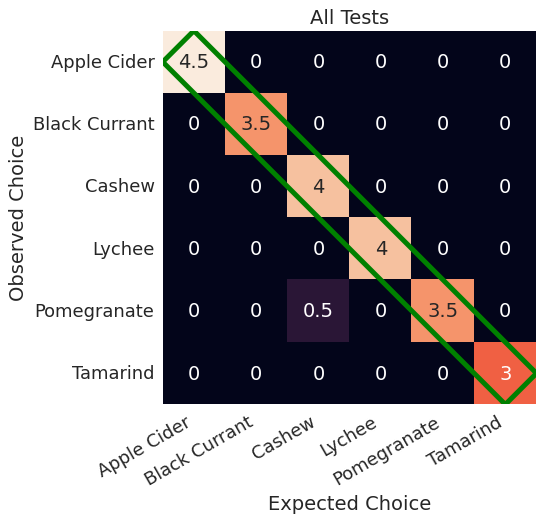

In [167]:
fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=90)

mat = np.nanmedian(fractal_confMatrix_ALL, axis = 2)
fractal_confMatrixALL_fig = plot_heatmap(mat, labels, ax, 'All Tests')

#### Tests

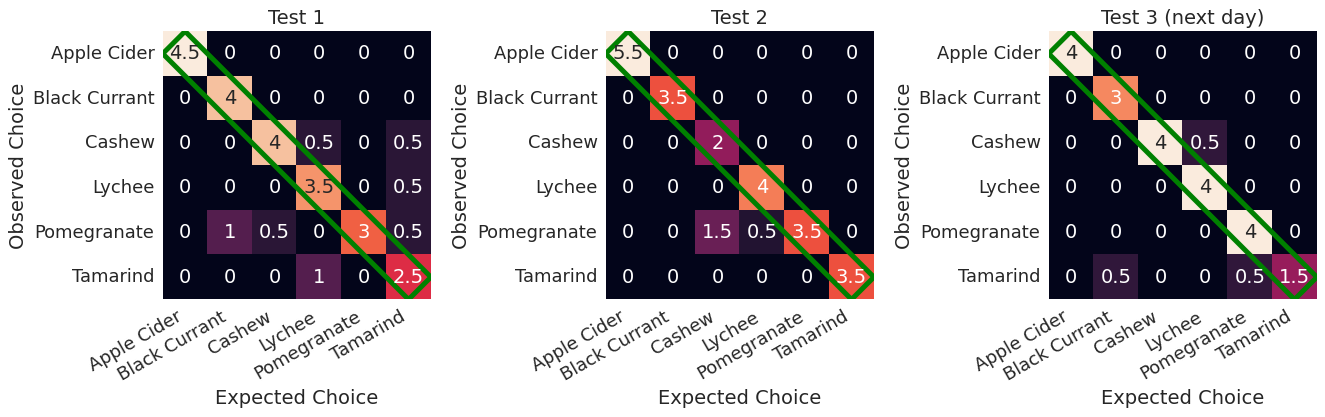

In [168]:
fig, ax = plt.subplots(1,3, figsize=(15, 5.5), dpi=90)
mat = np.nanmedian(fractal_confMatrix_1, axis = 2)
fractal_confMatrix1_fig = plot_heatmap(mat, labels, ax[0], 'Test 1')

mat = np.nanmedian(fractal_confMatrix_2, axis = 2)
fractal_confMatrix2_fig = plot_heatmap(mat, labels, ax[1], 'Test 2')

mat = np.nanmedian(fractal_confMatrix_3, axis = 2)
fractal_confMatrix3_fig = plot_heatmap(mat, labels, ax[2], 'Test 3 (next day)')

plt.tight_layout()

### Order

In [146]:
order_confMatrix_ALL = np.dstack((order_confMatrix_1, order_confMatrix_2, order_confMatrix_3))
order_labels = ['First', 'Second', 'Third', 'Forth', 'Fith', 'Sixth']
labels = order_labels

#### ALL

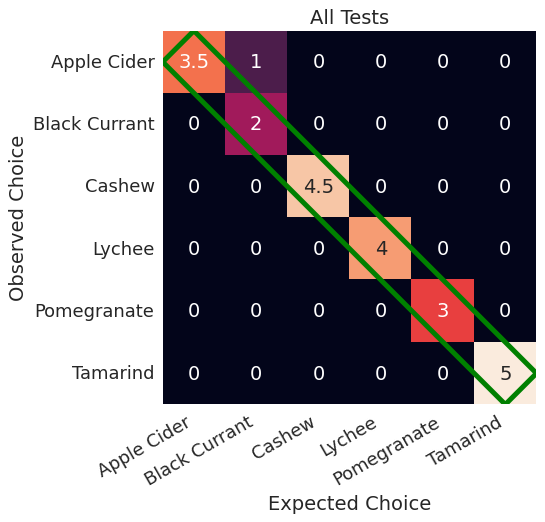

In [171]:
fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=90)

mat = np.nanmedian(order_confMatrix_ALL, axis = 2)
order_confMatrixALL_fig = plot_heatmap(mat, labels, ax, 'All Tests')

#### Tests

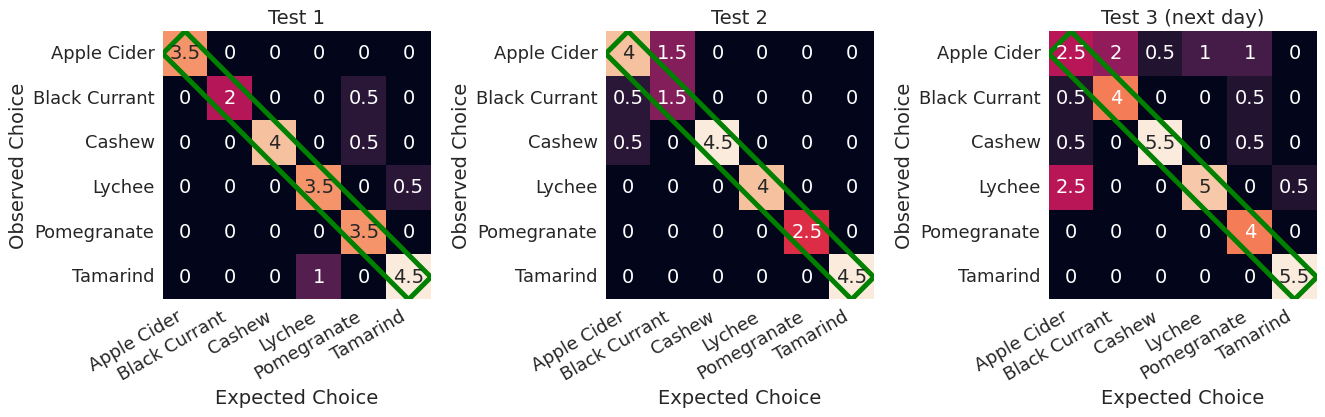

In [169]:
fig, ax = plt.subplots(1,3, figsize=(15, 5.5), dpi=90)
mat = np.nanmedian(order_confMatrix_1, axis = 2)
order_confMatrix1_fig = plot_heatmap(mat, labels, ax[0], 'Test 1')

mat = np.nanmedian(order_confMatrix_2, axis = 2)
order_confMatrix2_fig = plot_heatmap(mat, labels, ax[1], 'Test 2')

mat = np.nanmedian(order_confMatrix_3, axis = 2)
order_confMatrix3_fig = plot_heatmap(mat, labels, ax[2], 'Test 3 (next day)')

plt.tight_layout()

### Flavor

In [173]:
flavor_confMatrix_ALL = np.dstack((flavor_confMatrix_1, flavor_confMatrix_2, flavor_confMatrix_3))
flavor_labels = list(flavorDecoder.keys)
labels = flavor_labels

TypeError: ignored

#### ALL

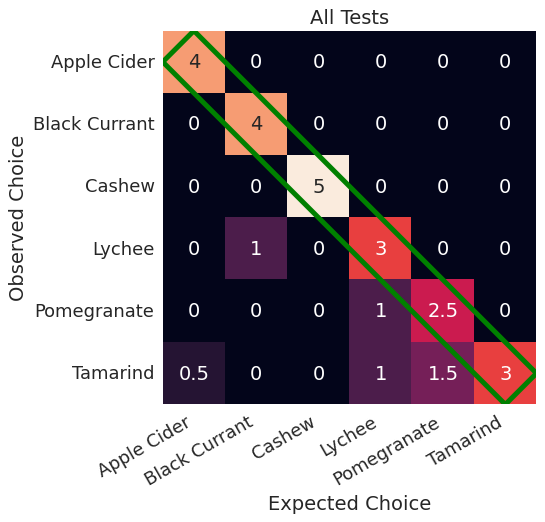

In [172]:
fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=90)

mat = np.nanmedian(flavor_confMatrix_ALL, axis = 2)
flavor_confMatrixALL_fig = plot_heatmap(mat, labels, ax, 'All Tests')

#### Tests

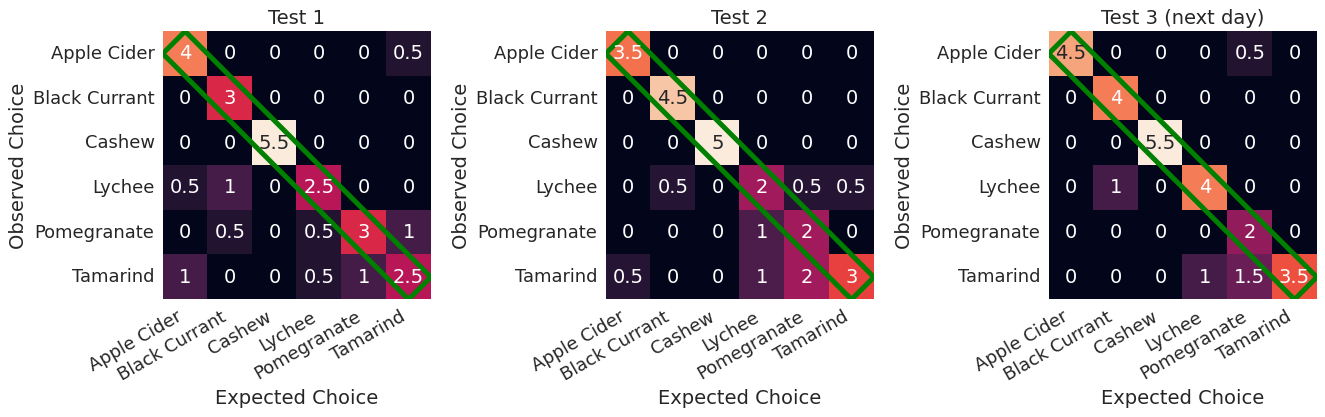

In [170]:
fig, ax = plt.subplots(1,3, figsize=(15, 5.5), dpi=90)
mat = np.nanmedian(flavor_confMatrix_1, axis = 2)
flavor_confMatrix1_fig = plot_heatmap(mat, labels, ax[0], 'Test 1')

mat = np.nanmedian(flavor_confMatrix_2, axis = 2)
flavor_confMatrix2_fig = plot_heatmap(mat, labels, ax[1], 'Test 2')

mat = np.nanmedian(flavor_confMatrix_3, axis = 2)
flavor_confMatrix3_fig = plot_heatmap(mat, labels, ax[2], 'Test 3 (next day)')

plt.tight_layout()